# Example: Gaussian Mixture

- 2020-11-29 first uploaded
- 2021-04-08 backward loss updated

In [1]:
from abc import ABC

import matplotlib.pyplot as plt
import numpy as np
import itertools
from inn.flow import *
from inn.utils import *
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
print(tf.__version__)
!python --version

2.5.0
Python 3.8.2


## Settings

In [2]:
n_means = 8
radius = 14
sd = 1
labels = ['red','gold','green','chocolate','blue','magenta','pink','purple']
# labels = ['red','red','red','red','blue','blue','green','purple']
assert len(labels) == n_means

x_dim = 2
y_dim = len(list(set(labels)))
z_dim = 2
tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim
n_sample = 200
n_data = n_sample * n_means
n_couple_layer = 3
n_hid_layer = 3
n_hid_dim = 512

n_batch = 200
n_epoch = 2000
n_display = 100

(8, 200, 2)


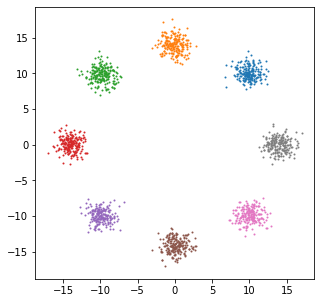

In [3]:
# Make data
X_raw = np.zeros((n_means, n_sample, x_dim), dtype='float32')
for i in range(n_means):
    th = 2*np.pi / n_means * (i+1)
    mean = [radius*np.cos(th), radius*np.sin(th)]
    X_raw[i, :, :] = np.random.multivariate_normal(mean, np.identity(x_dim)*sd, size=n_sample)

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')
for i in range(n_means):
    ax.scatter(X_raw[i,:,0], X_raw[i,:,1], s=1)
print(X_raw.shape)

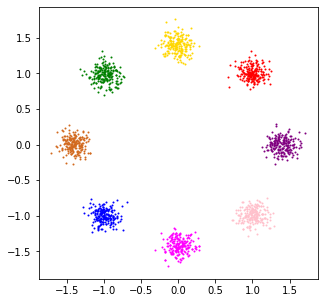

In [4]:
# Preprocess
uq_labels = list(set(labels))
idx2lab = {i:lab for i, lab in enumerate(uq_labels)}
lab2idx = {idx2lab[key]:i for i, key in enumerate(idx2lab.keys())}

X = X_raw.reshape((-1, x_dim))
X = StandardScaler().fit_transform(X)
y = [[lab2idx[lab]]*n_sample for lab in labels]
y = list(itertools.chain.from_iterable(y)) # flatten
y_onehot = np.eye(len(uq_labels))[y].astype('int')

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y]
    ax.scatter(X[idx,0], X[idx,1], s=1, c=color)

In [5]:
# Pad data
pad_x = np.zeros((X.shape[0], pad_dim))
x_data = np.concatenate([X, pad_x], axis=-1).astype('float32')
z = np.random.multivariate_normal([0.]*x_dim, np.eye(x_dim), X.shape[0])
y_data = np.concatenate([z, y_onehot], axis=-1).astype('float32')

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x_data)
y_data = tf.data.Dataset.from_tensor_slices(y_data)
dataset = (tf.data.Dataset.zip((x_data, y_data))
           .shuffle(buffer_size=X.shape[0])
           .batch(n_batch, drop_remainder=True)
           .repeat())

2021-07-03 14:06:47.212433: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initialize the model

In [6]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name='NVP')
x = tfk.Input((tot_dim,))
model(x);
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer0 (TwoNVPCouplingLayers multiple                  1067038   
_________________________________________________________________
Layer1 (TwoNVPCouplingLayers multiple                  1067038   
_________________________________________________________________
Layer2 (TwoNVPCouplingLayers multiple                  1067038   
Total params: 3,201,114
Trainable params: 3,201,084
Non-trainable params: 30
_________________________________________________________________


In [7]:
class Trainer(tfk.Model, ABC):
    def __init__(self, model, x_dim, y_dim, z_dim, tot_dim, 
                 n_couple_layer, n_hid_layer, n_hid_dim, shuffle_type='reverse'):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = 5.
        self.w2 = 1.
        self.w3 = 10.
        self.loss_factor = 1.
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MMD_multiscale

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, :self.x_dim]
        y = y_data[:, -self.y_dim:]
        z = y_data[:, :self.z_dim]
        y_short = tf.concat([z, y], axis=-1)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)    
            pred_loss = self.w1 * self.loss_fit(y_data[:,self.z_dim:], y_out[:,self.z_dim:]) # [zeros, y] <=> [zeros, yhat]
            output_block_grad = tf.concat([y_out[:,:self.z_dim], y_out[:, -self.y_dim:]], axis=-1) # take out [z, y] only (not zeros)
            latent_loss = self.w2 * self.loss_latent(y_short, output_block_grad) # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            #rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_backward, self.model.trainable_weights)) 

        total_loss = forward_loss + latent_loss + rev_loss
        return {'total_loss': total_loss,
                'forward_loss': forward_loss,
                'latent_loss': latent_loss,
                'rev_loss': rev_loss}

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [8]:
trainer = Trainer(model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim)
trainer.compile(optimizer='adam')

## Train the model

In [9]:
%%time
LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)
hist = trainer.fit(dataset,
                   batch_size=n_batch,
                   epochs=n_epoch,
                   steps_per_epoch=n_data//n_batch, 
                   callbacks=[logger, LossFactor], 
                   verbose=0)

=== Started at 2021-07-03 12h:06m:53s ===


2021-07-03 14:06:54.940414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


 2021-07-03 12h:06m:55s | Epoch: 0001/2000 | total_loss=2.282215 forward_loss=0.493120 latent_loss=0.179116 rev_loss=1.609979
 2021-07-03 12h:07m:24s | Epoch: 0100/2000 | total_loss=0.348337 forward_loss=0.058438 latent_loss=0.042474 rev_loss=0.247425
 2021-07-03 12h:07m:52s | Epoch: 0200/2000 | total_loss=0.274932 forward_loss=0.049967 latent_loss=0.037255 rev_loss=0.187710
 2021-07-03 12h:08m:19s | Epoch: 0300/2000 | total_loss=0.223468 forward_loss=0.032180 latent_loss=0.028651 rev_loss=0.162636
 2021-07-03 12h:08m:46s | Epoch: 0400/2000 | total_loss=0.187617 forward_loss=0.027556 latent_loss=0.025581 rev_loss=0.134480
 2021-07-03 12h:09m:14s | Epoch: 0500/2000 | total_loss=0.254847 forward_loss=0.030615 latent_loss=0.028037 rev_loss=0.196195
 2021-07-03 12h:09m:43s | Epoch: 0600/2000 | total_loss=0.200318 forward_loss=0.029484 latent_loss=0.026554 rev_loss=0.144280
 2021-07-03 12h:10m:11s | Epoch: 0700/2000 | total_loss=0.188212 forward_loss=0.029754 latent_loss=0.028124 rev_loss=0

KeyboardInterrupt: 

## Check results

NameError: name 'hist' is not defined

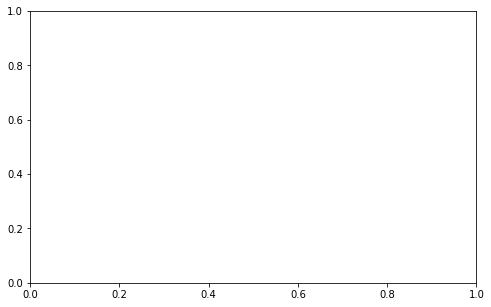

In [10]:
fig, ax = plt.subplots(1, facecolor='white', figsize=(8,5))
ax.plot(hist.history['total_loss'], 'k.-', label='total_loss')
ax.plot(hist.history['forward_loss'], 'b.-', label='forward_loss')
ax.plot(hist.history['latent_loss'], 'g.-', label='latent_loss')
ax.plot(hist.history['rev_loss'], 'r.-', label='inverse_loss')
plt.legend()

In [ ]:
z = np.random.multivariate_normal([1.]*z_dim, np.eye(z_dim), y_onehot.shape[0])
y = np.concatenate([z, y_onehot], axis=-1).astype('float32')
x_pred = model.inverse(y).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), facecolor='white', sharex=True, sharey=True)
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y_onehot.argmax(axis=-1)]
    ax1.scatter(X[idx,0], X[idx,1], s=1, c=color)
    ax2.scatter(x_pred[idx,0], x_pred[idx,1], s=1, c=color)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([-2, 2])
plt.suptitle('Original (left)                    Prediction (right)', fontsize=20);